In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


1 Introduction

MNIST ("Modified National Institute of Standards and Technology") is the classic dataset of handwritten images, since its release in 1999. A new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike. The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Import the necessary libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
import tensorflow as tf

sns.set(style='white', context='notebook', palette='deep')

2 Data preparation

2.1 Load data

In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')
sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

print("Data are Ready!!")

Data are Ready!!


In [4]:
train.shape

(42000, 785)

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.shape

(28000, 784)

In [7]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
sub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


Set data features and Target labels

In [9]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1) 

Load more data sets

In [10]:
# Load more data sets, if there is no such data, validation accuracy = 0.9964
# With this batch of data, the validation accuracy can reach 0.9985
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

Y_train1 = y_train1
X_train1 = train1.reshape(-1, 28*28)

11501568/11490434 [==============================] - 0s 0us/step


Balance on Target Label

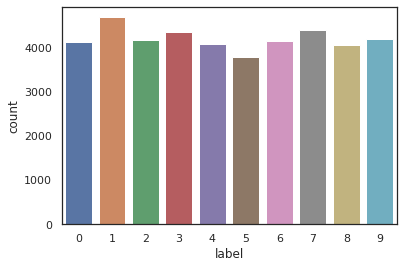

In [11]:
# Print data histogram
sns.countplot(Y_train);

2.2 Normalization

Perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [12]:
# Normalize data to make CNN faster
X_train = X_train / 255.0
test = test / 255.0

X_train1 = X_train1 / 255.0

Merging all the data

In [13]:
X_train = np.concatenate((X_train.values, X_train1))
Y_train = np.concatenate((Y_train, Y_train1))

2.3 Reshape

In [14]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X_train = X_train.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

One-Hot Encoding

Labels are 10 digits numbers from 0 to 9. Need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [15]:
# Convert label to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

2.5 Split training and valdiation set

Let's split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [16]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

In [17]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((100800, 28, 28, 1), (11200, 28, 28, 1), (100800, 10), (11200, 10))

In [18]:
print(Y_train[0])
#print(X_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Data Visualization

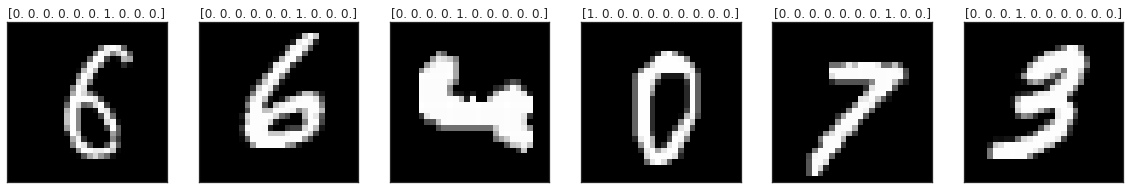

In [19]:
# plot first six training images
fig = plt.figure(figsize=(20,20))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i].reshape(28,28), cmap='gray')
    ax.set_title(str(Y_train[i]))

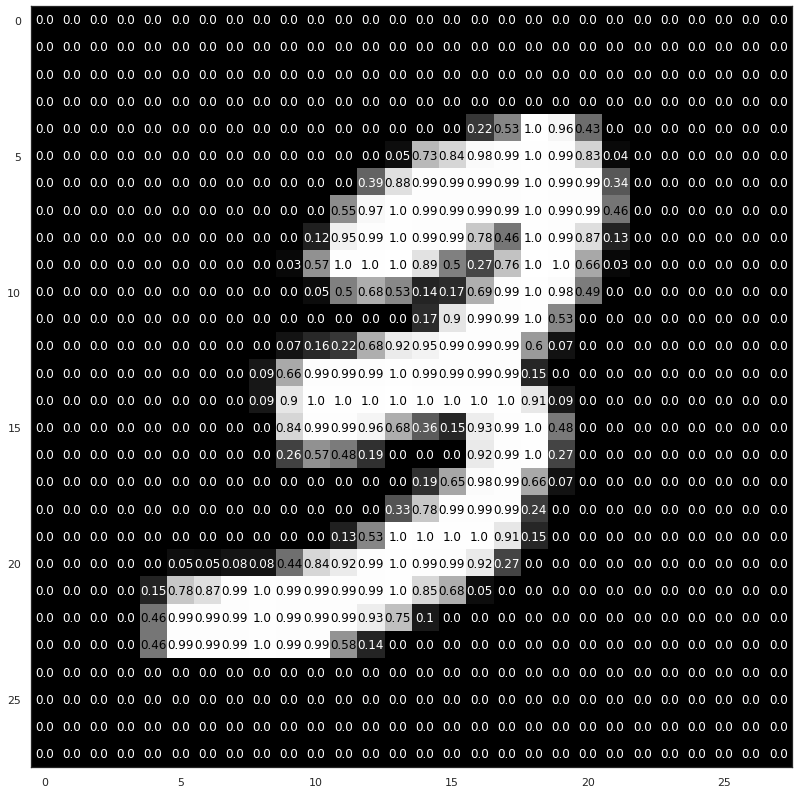

In [20]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (14,14)) 
ax = fig.add_subplot(111)
visualize_input(X_train[5].reshape(28,28), ax)

3 CNN

3.1 Define the model

It was used the Keras Sequential API, where have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. It was choosed to set 64 filters for the two firsts conv2D layers and 64 filters for the two second layers and 64 filters for one third layers and 256 for the last one. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. Have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

'Relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end it was used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

Model Definition:

In [21]:
#Creating CNN model
"""
  [[Conv2D->relu]*2 -> BatchNormalization -> MaxPool2D -> Dropout]*2 -> 
  [Conv2D->relu]*2 -> BatchNormalization -> Dropout -> 
  Flatten -> Dense -> BatchNormalization -> Dropout -> Out
"""
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))

2022-06-02 01:32:40.407704: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
# Define Optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [23]:
# Compile model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [24]:
# Audjusting learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
# Adjusting epochs and batch_size
epochs = 50
batch_size = 128

3.2 Data augmentation

In order to avoid overfitting problem, it's need to expand artificially the handwritten digit dataset. Can make the existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example: the number is not centered; the scale is not the same (some who write with big/small numbers); the image is rotated...

Approaches that alter the training data in ways that change the array representation while "keeping the label the same" are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to training data, can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

Without data augmentation it was obtained an accuracy of 99.114%. But with data augmentation it was achieved 99.985% of accuracy. Therefore, a difference about 1%.

For the data augmentation, it was choosed to:

- Randomly rotate some training images by 10 degrees;
- Randomly Zoom by 10% some training images;
- Randomly shift images horizontally by 10% of the width;
- Randomly shift images vertically by 10% of the height;
- It was not applied a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

In [26]:
# Data Augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# datagen.fit(X_train)
train_gen = datagen.flow(X_train,Y_train, batch_size=batch_size)

3.3 Model training

In [27]:
#Prediction model
history = model.fit(train_gen,
                              epochs = epochs,validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],
                             validation_steps = X_val.shape[0] // batch_size)

2022-06-02 01:32:42.063455: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
787/787 - 581s - loss: 0.1411 - accuracy: 0.9563 - val_loss: 0.0394 - val_accuracy: 0.9888
Epoch 2/50
787/787 - 580s - loss: 0.0487 - accuracy: 0.9850 - val_loss: 0.0356 - val_accuracy: 0.9893
Epoch 3/50
787/787 - 588s - loss: 0.0379 - accuracy: 0.9883 - val_loss: 0.0167 - val_accuracy: 0.9946
Epoch 4/50
787/787 - 584s - loss: 0.0333 - accuracy: 0.9904 - val_loss: 0.0178 - val_accuracy: 0.9941
Epoch 5/50
787/787 - 578s - loss: 0.0307 - accuracy: 0.9908 - val_loss: 0.0165 - val_accuracy: 0.9947
Epoch 6/50
787/787 - 575s - loss: 0.0259 - accuracy: 0.9921 - val_loss: 0.0197 - val_accuracy: 0.9940
Epoch 7/50
787/787 - 574s - loss: 0.0246 - accuracy: 0.9924 - val_loss: 0.0123 - val_accuracy: 0.9962
Epoch 8/50
787/787 - 574s - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0142 - val_accuracy: 0.9953
Epoch 9/50
787/787 - 571s - loss: 0.0224 - accuracy: 0.9932 - val_loss: 0.0127 - val_accuracy: 0.9967
Epoch 10/50
787/787 - 573s - loss: 0.0215 - accuracy: 0.9935 - val_loss: 0.0187 - 

4 Evaluate the model

4.1 Training and validation curves

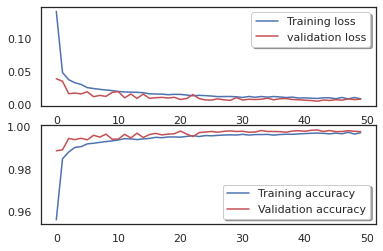

In [28]:
# Draw the loss and accuracy curves of the training set and the validation set.
# Can judge whether it is under-fitting or over-fitting
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

4.2 Confusion matrix

Confusion matrix can be very helpful to see model drawbacks and behavior. Let's plot the confusion matrix of the validation results:

In [29]:
# Draw a confusion matrix that can be used to observe high false positives

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

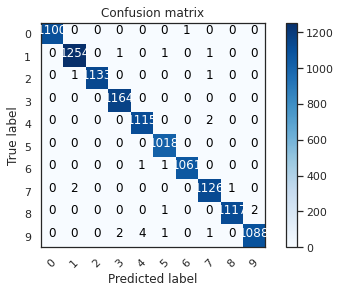

In [30]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Displaying The Errors And Showing The Top 6 Errors And It's True Label:

In [31]:
# Show some wrong results, and the difference between the predicted label and the real labe
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [32]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

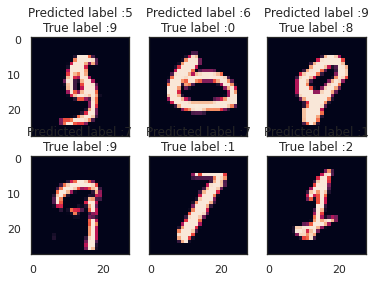

In [33]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

5 Prediction and submition

5.1 Prediction validation results

In [34]:
# Make predictions about test sets
results = model.predict(test)

# Convert one-hot vector to number
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [35]:
# Save the final result in cnn_mnist_submission.csv
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_submission.csv",index=False)

In [36]:
print(submission)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


References:

- <https://www.kaggle.com/code/ahmed121ashraf131/mnist-simple-cnn-knn-accuracy-100-top-1>;
- <https://www.kaggle.com/code/raghaw/mnist-cnn-external-data-perfect-score>;
- <https://www.kaggle.com/code/nakulsingh1289/score-1-00-in-digit-recognizer>.